# Mini-project



## General guidelines

We want to make a typical study of a ML problem.

We're going to use Fashion-MNIST ("*fashion-mnist-reshaped.npz*")  as data set, attempting to classify the pictures correctly.

There are 2 parts in the project:
- use `DecisionTreeClassifier` and PCA from sklearn to classify the data
- make your own multi-class classifier, deriving its updates from scratch
The first part weights more in the total grade than the second one.

In the first part, the goal is to showcase a typical hyper-parameter tuning. We will simulate the fact of having different tasks by restricting ourselves to different dataset size, and comment on how hyper-parameters choice can depend a lot on how much data we have at hand.

General advice: **write clean code**, well factored in functions/classes, for each question, as much as possible.
This will make your code **easier to read and also easier to run!**. You may re-use code in several questions. If it's  well factored, it will be easier to code the next questions.

Tips: you may want to use 
- `sklearn.tree.DecisionTreeClassifier`
- `sklearn.model_selection.train_test_split`
- `sklearn.decomposition.PCA`
- `sklearn.model_selection.cross_validate` 

to lighten your code.

## Part 1: using `sklearn.tree.DecisionTreeClassifier`

## (about 15 points over 20 total)

Decision Trees are powerful methods, however they can easily overfit. The number of parameters in the model essenitially grows like $\sim O(2^{maxDepth})$, i.e. exponentially with the depth of the tree.

### Part 1.1: `Ntrain+Nval=2000, Nvalid=1000`

In this part we use this amount of data.
- import the data, split the "train+validation" sets. Keep the test set for the **very** end.
- attempt direct classification using a `sklearn.tree.DecisionTreeClassifier`. Optimize the hyper-parameter `max_depth`. Measure and store the validation accuracy for the best choice of `max_depth`.
Do you fear you may be overfitting ? Explain your answer.
- Now, let's add some PCA as pre-processing. 
    - Using `max_depth=5`, what is the best number of PCA components (nComp_PCA) to keep ? Hint: you may use something like `nComp_range = np.array(list(np.arange(1,50))+[50,100,200,400,783,784])` as the range of nComp_PCA values to be explored.
    - Using `max_depth=12`, what is the best number of PCA components (nComp_PCA) to keep ?
    - Can you explain why this optimal number changes with depth ? 
- Find the best (max_depth, nComp_PCA) pair. 
- Can you explain the behavior of the optimal `max_depth`, let's call it $m*$, with `nComp_PCA`, at **small** `nComp_PCA` ?
- Can you explain the behavior of the optimal `max_depth`, let's call it $m*$, with `nComp_PCA`, at **large** `nComp_PCA` ?
- Measure the cross-validation error for this best pair. Are you surprised with the result?

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
LoadObject = np.load("fashion-mnist-reshaped.npz") # please put your data over there so it's easy for me to run your code
linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
## we do not use the TEST SET for now:
# Xtest = LoadObject['test_images']
# ytest = LoadObject['test_labels']

In [23]:
df=pd.DataFrame(data=X)
df.shape

(60000, 784)

#### define ratios 

In [24]:
Ntrain = 1216
Nval=784
Nvalid = 1000

#### define split function

In [25]:
from sklearn.model_selection import train_test_split
def split(X,y,Ntrain,Nval,Nvalid):
    #X y for the training and scoring
    X_train_val, X_rest,y_train_val,y_rest= train_test_split(X, y, train_size=Ntrain+Nval)
    X_train,X_val,y_train,y_val=train_test_split(X_train_val, y_train_val, train_size=Ntrain)

    #X y for the cross validation
    X_valid,y_valid,X_rest,y_rest , =train_test_split(X_train_val, y_train_val, train_size=Nvalid)
    return {'X_train':X_train,
           'y_train':y_train,
           'X_val':X_val,
           'y_val':y_val,
           'X_valid':X_valid,
           'y_valid':y_valid}
#split(X,y,Ntrain,Nval,Nvalid)


#### data for the first part

In [26]:
data=split(X,y,Ntrain,Nval,Nvalid)
X_train=data['X_train'] 
y_train=data['y_train']
X_val=data['X_val']
y_val=data['y_val']

#### max_depth search

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

#fit the classifyer then return it
def classifyer(X_train, y_train,nC=5):
    if(nC==0):
        clf=DecisionTreeClassifier(max_depth=None)
    else:
        clf=DecisionTreeClassifier(max_depth=nC)
    clf.fit(X_train, y_train)
    return clf

#getting score
def get_score(clf,X_val,y_val,metric=accuracy_score):
    y_pred=clf.predict(X_val)
    return metric(y_pred,y_val)
    
#faire varier max_depth et renvoyer les ainsi que les scores qui y sont associés
def get_max_depth_scores(max_max_depth,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val):
    #to store max_depth == scores
    max_depth_scores=[]
    for nC in range(max_max_depth+1):
        clf=classifyer(X_train, y_train)
        score = get_score(clf,X_val,y_val)
        max_depth_scores.append([nC,score])
    return max_depth_scores 


#### limit_max of max_depth

In [38]:
limit_max=100
d=get_max_depth_scores(limit_max)

<AxesSubplot:xlabel='max_depth'>

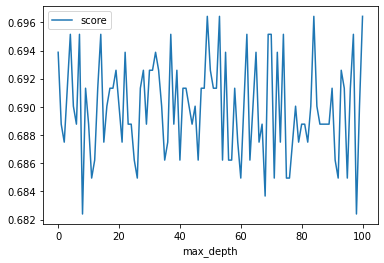

In [29]:
scores=pd.DataFrame(data=d,columns=['max_depth','score'])
scores.plot(x='max_depth',y='score')

In [30]:
#the score max and the corresponding max_depth value
scores[scores['score']==scores['score'].max()]

,max_depth,score
49,49,0.696429
53,53,0.696429
84,84,0.696429
100,100,0.696429


### PCA part

In [31]:
from sklearn.decomposition import PCA
nComp_range = np.array(list(np.arange(1,50))+[50,100,200,400,783,784])

def apply_pca(X,n_comp):
    pca=PCA(n_components=n_comp)
    return pca.fit_transform(X)

def classifyer_with_pca(X_train,y,n_comp_pca,max_depth=5):
    return classifyer(apply_pca(X_train,n_comp_pca),y,max_depth)

def get_pca_scores(X,y,n_comp=nComp_range,max_depth=5,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val):
    #to store n_componenet_pca == scores
    pca_scores=[]
    for n in n_comp:
        clf=classifyer_with_pca(X_train,y_train,n,max_depth)
        score=get_score(clf,apply_pca(X_val,n),y_val,metric=accuracy_score)
        pca_scores.append([n,score])
    return pca_scores

<AxesSubplot:xlabel='pca_components'>

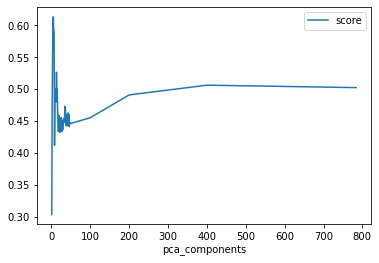

In [32]:
d=get_pca_scores(X,y)
scores=pd.DataFrame(data=d,columns=['pca_components','score'])
scores.plot(x='pca_components',y='score')

In [33]:
scores[scores['score']==scores['score'].max()]

,pca_components,score
4,5,0.61352


<AxesSubplot:xlabel='pca_components'>

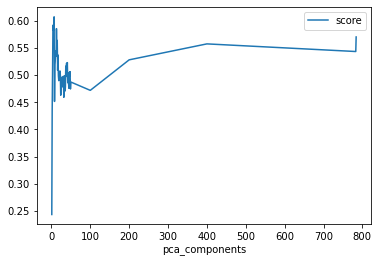

In [34]:
d=get_pca_scores(X,y,max_depth=12)
scores=pd.DataFrame(data=d,columns=['pca_components','score'])
scores.plot(x='pca_components',y='score')

In [36]:
scores[scores['score']==scores['score'].max()]

,pca_components,score
6,7,0.607143


#### Measure and store the validation accuracy for the best choice of max_depth. Do you fear you may be overfitting ? Explain your answer.

answer here:

### Part 1.2: `Ntrain+Nval=5000, Nvalid=2000`

If you factored your code decently in the last questions, this should be very easy/fast to do. Ideally, it should be a couple of lines and a single function call. (For the core computation, excluding plots and presentation)
- split the "train+validation" sets. 
- Find the best (max_depth, nComp_PCA) pair. 
- Measure the cross-validation error for this best pair. Are you surprised with the result?


### Part 1.3: `Ntrain+Nval=20000, Nvalid=10000`

If you factored your code decently in the last questions, this should be very easy/fast to do. Ideally, it should be a couple of lines and a single function call. (For the core computation, excluding plots and presentation)
- split the "train+validation" sets.
- Find the best (max_depth, nComp_PCA) pair. 
- Measure the cross-validation error for this best pair. Are you surprised with the result?

**Hint: to save compute time, you can use a smaller hyper-parameter search space, i.e. you can reduce the umber of values explored in your hyper-optimization.**

### Part 1.4: The test (with `Ntest=10000`)
Use your best model to make a prediction:
- Which model do you prefer, among the 3 "best models" you have found? Why? How confident are you with your choice?
- Using your `Ntest=10000` samples that you saved preciously (and NEVER used), compute the test error. How surprised are you with the result? 
- If you were asked by a client, "what is the level of accuracy you can achieve", what would be your answer ?


In [ ]:
# Xtest = LoadObject['test_images']
# ytest = LoadObject['test_labels']


### Part 1.4 - Bonus question : 
- Compute also the cross validation error for the best hyper parameters choice with `N_train=200`
- Plot the cross validation error as a function of ntrain= 200,2000,20000  
- People often say "let's just get more data". How efficient does that does seem to be ? 

## Part 2: make your own classifier !

## (about 5 points over 20 total)

The multi-class percpetron can be implemented this way. 
We denote $K$ the number of classes, $N$ the number of (training) examples, $D$ the dimension of the data (after feature augmentation, at least with a "1" as first component).

The **output** of the network *(not equal to the predicted label)*, can be taken as the **softmax** among the $K$ separating hyperplanes (each hyperplane $\vec{w}_k$ separates class $k$ from the others).
$$ y_k^{(n)} = \text{softmax}\big( (\vec{w}_{k} \cdot \vec{x}^{(n)})_{k=1...K} \big) = \frac{ \exp(  \vec{w}_k\cdot\vec{x}^{(n)}   )}{\sum_\ell \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})}$$
This output can be **interpreted as the probability** that example $x^{(n)}$ belongs to the class $k$, according the classifier's current parameters
Indeed, one can easily check that for any $\vec{x}$, the sum of probabilities is indeed one : $\sum_k y_k = 1$.
The **total output of the network** is a vector $\vec{y}^{(n)} = \begin{pmatrix}y_1^{(n)} \\ y_2^{(n)} \\ .. \\ y_K^{(n)} \end{pmatrix}$ (for the sample number $n$).

The **true labels (ground truth)** of example $\vec{x}^{(n)}$ is then encoded as a one-hot vector, so that if the example is of the second class, it may be written: $\vec{t}^{n} = \begin{pmatrix} 0 \\ 1 \\ 0 \\ .. \\ 0 \end{pmatrix}$. (where $\vec{t}^{(n)}$ or $\vec{t}^{n}$ is for **T**ruth and is shorter to write than $\vec{y}^{GT,(n)}$). More generally, the components $t_{n,k}$ of vector $\vec{t}_n$ may be written using the Kronecker's delta: $t_{n,k} = \delta(k, k_{true}^n)$, where $k_{true}^n$ is the true class of example number $n$.

From now on, **we drop the superscrip $a^{(n)}$ and instead write $a_n$ or just $a$**, when it's clear enough that the quantity $a$ relates to a single example, of generic index $n$. This helps to lighten the notations.

The Loss function that we should use is called the **cross-entropy loss function**, and is:

$$J = \frac1N \sum_n^N H(\vec{t}_{n}, \vec{y}_{n})$$

where the cross-entropy is a non-symmetric function: $$H(\vec{t}_{n}, \vec{y}_{n}) = -\sum_k^K t_{n,k} \log (y_{n,k})$$ 

Make sure you undersand all of the above. Write down the Loss function for the multi-class perceptron. 
### Part 2.1
- What are the parameters of the model ? **How many real numbers is that ?** Count them in terms of $N,K,D, etc$. 
- (3-4 points) **Derive the update steps for the gradient**. (you can get inspiration from TD4.1)
- Some Hints:
    - It is recommended to compute the quantity $\nabla_{w_\ell} y_k$ ($\ell\neq k$) and the quantity $\nabla_{w_k} y_k$. Try to express these simply, by recognizing $y$ when it appears. First treat the two cases separately, then try to unite the two cases in a single mathematical form, using Kronecker's delta : $\delta(i,j)= \{1$ if $i=j$, else $0\}$.
    - When there is a sum $\sum_\ell f(w_\ell)$ and you derive with respect to $w_k$, the output only depends on the term $f(w_k)$ 
    - In the sum above, $\sum_\ell f(w_\ell)$ the index $\ell$ is a "mute" index: you can use any letter for it. Be careful not to use a letter that already exists outside the sum ($\ell$ is like a local variable, don't use the same name for a "global variable" from outside the function !)
    - For any functions $u,v$ that admit derivatives, $\partial_x \frac{u(x)}{v(x)} = \frac{u'(x)v(x)-u(x)v'(x)}{(v(x))^2}$. It extends to $\nabla_x$ without problem.
    - $\nabla_x \exp(u(x)) =  \exp(u(x)) \nabla_x u(x)$.
    - $\frac{a}{1+a} = 1- \frac{1}{1+a}$
    - $\partial_x \log(u(x)) = \frac{u'(x)}{u(x)}$ 
    - If you are too much blocked, you can ask me (via discord, in Private Message) for the solution of $\nabla_{w_k} y_k$ and/or the solution for $\nabla_{w_\ell} y_k$ ($\ell\neq k$).
    - In the end, the update step for the parameters that you should find is : $$ \vec{w}_\ell \mapsto \vec{w}_\ell + \eta \frac1N \sum_n^N \vec{x}_n (\delta_{\ell, k_{true}^n}- y_{\ell,n})$$
    - If you cannot find the equation above, you can just skip this question and use it to make your program.
    
    

### Part 2.2
- (3 points) **Think up of all the functions you need to write**, and **put them in a class** (you can get inspiration from the correction of TP3.2) - first write a class skeleton, and **only then, write the methods** inside
- Hints:
    - there may be numerical errors (NaNs) because $\exp(..)$ is too large. You can ease this by noticing the following: for any positive constant $C$, we have $$\frac{ \exp( a_k  )}{\sum_\ell \exp (a_\ell) }  = \frac{C \exp( a_k  )}{C \sum_\ell \exp (a_\ell) }= \frac{\exp( a_k +\log C )}{\sum_\ell \exp (a_\ell +\log C) }$$
    - with this trick, when your arguments in the softmax are too large, you can simply subtract a big constant $\log C$ from its argument, and this will reduce the chances of numerical error, without changing the result. It's a good idea to change the $w $'s with this kind of trick.
    - it's a good idea to define the target labels (ground truth) data in one-hot vectors (as said above), compute them once and for all, and then you never have to compute them again. In practice, you may notice that for an example with label $k_{true}$, then the genreic component number of $k$ of the vector $\vec{t}$ reads: $t_{k} = \delta_{k, k_{true}}$
    - the initial $w$ should be random (not all zeros), preferably, but not too big. A good idea is to have their dispersion be of order $1/D$ at most.
    
For this question, the main goal is to make a theoretically-working, rather clean code, using numpy array-operations (`np.dot`) and not loops, as much as possible. If you manage to do that, you will most likely have a working code (and fast code!)
- (1 point) Test your algorithm on Fashion-MNIST: make a train / validation / test split , fit the model, compute the cross-val error, and the test error. Don't waste time on optimizing hyper-parameters (just take an $\eta$ small enough that you kind of converge. The goal is really to prove that your algorithm does not always crash :)

In [1]:
## remark:
import numpy as np
print(np.exp(100))

2.6881171418161356e+43


In [9]:
print(np.exp(800)- np.exp(800))

nan


/home/flandes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/home/flandes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
